In [1]:
import base64
#import cStringIO
import sys
import tempfile
import time
MODEL_BASE = '/Users/aadebuger/GEXT/github2019/models/research'
MODEL_BASE = '/home/aadebugergf/Ai/github2019/models/research'


sys.path.append(MODEL_BASE)
sys.path.append(MODEL_BASE + '/object_detection')
sys.path.append(MODEL_BASE + '/slim')


import numpy as np
from PIL import Image
from PIL import ImageDraw
import tensorflow as tf
from utils import label_map_util




PATH_TO_CKPT = '/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_LABELS = MODEL_BASE + '/object_detection/data/mscoco_label_map.pbtxt'

content_types = {'jpg': 'image/jpeg',
                 'jpeg': 'image/jpeg',
                 'png': 'image/png'}
extensions = sorted(content_types.keys())


def is_image():
  def _is_image(form, field):
    if not field.data:
      raise ValidationError()
    elif field.data.filename.split('.')[-1].lower() not in extensions:
      raise ValidationError()

  return _is_image





class ObjectDetector(object):

  def __init__(self):
    self.detection_graph = self._build_graph()
    self.sess = tf.Session(graph=self.detection_graph)

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    self.category_index = label_map_util.create_category_index(categories)

  def _build_graph(self):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    return detection_graph

  def _load_image_into_numpy_array(self, image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

  def detect(self, image):
    image_np = self._load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = self.detection_graph
    image_tensor = graph.get_tensor_by_name('image_tensor:0')
    boxes = graph.get_tensor_by_name('detection_boxes:0')
    scores = graph.get_tensor_by_name('detection_scores:0')
    classes = graph.get_tensor_by_name('detection_classes:0')
    num_detections = graph.get_tensor_by_name('num_detections:0')

    (boxes, scores, classes, num_detections) = self.sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    boxes, scores, classes, num_detections = map(
        np.squeeze, [boxes, scores, classes, num_detections])

    return boxes, scores, classes.astype(int), num_detections


def draw_bounding_box_on_image(image, box, color='red', thickness=4):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  ymin, xmin, ymax, xmax = box
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  print("rect,width="+str(right-left)+"height="+str(bottom-top))
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  print('(left, right, top, bottom)',(left, right, top, bottom))

from io import BytesIO
def encode_image(image):
  image_buffer = BytesIO()
  image.save(image_buffer, format='PNG')
  imagevalue = image_buffer.getvalue()
  base64str=base64.b64encode(imagevalue).decode()

  imgstr = 'data:image/png;base64,{:s}'.format(
     base64str )
  return imgstr


def detect_objects(image_path):
  start = time.time()
  
  image = Image.open(image_path).convert('RGB')
  boxes, scores, classes, num_detections = client.detect(image)
  end = time.time()
  print("execute1 time",(end-start)) 
    
  image.thumbnail((480, 480), Image.ANTIALIAS)
  print(num_detections)
  new_images = {}
  for i in range(int(num_detections)):

    if scores[i] < 0.35: continue
    print("scres[i",scores[i])
        
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)

  result = {}
#  result['original'] = encode_image(image.copy())
  print(new_images)
  count = 0 
  for cls, new_image in new_images.items():
    category = client.category_index[cls]['name']
    print(category)
    result[category] = encode_image(new_image)
    new_image.save("{0}.jpg".format(count))
    count=count+1
  end = time.time()
  print("execute2 time",(end-start)) 
  return result



PATH_TO_CKPT='/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'

PATH_TO_CKPT='/home/aadebugergf/Ai/models/fastrcnnstbmodelrtx2/frozen_inference_graph.pb'

client = ObjectDetector()

execute1 time 4.446731805801392
200.0
scres[i 0.9999597
boxes [0.3160288 0.5453547 0.615237  0.7997998]
rect,width=122.13363647460938height=107.7149498462677
(left, right, top, bottom) (261.77026748657227, 383.90390396118164, 113.77036929130554, 221.48531913757324)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F9C440AABE0>}
bicycle
execute2 time 4.513382434844971
1



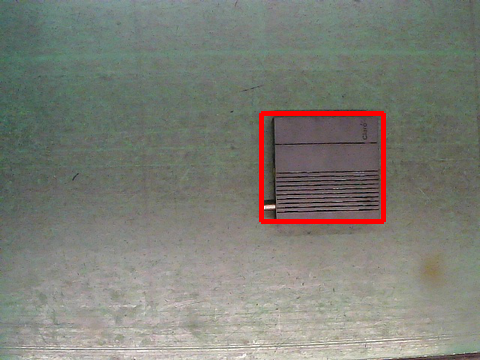

In [2]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.8837230205535889
200.0
scres[i 0.99999285
boxes [0.6663104  0.6735535  0.97239023 0.91697973]
rect,width=116.84457778930664height=110.188729763031
(left, right, top, bottom) (323.3056926727295, 440.15027046203613, 239.87175464630127, 350.0604844093323)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F14A03F9128>}
bicycle
execute2 time 0.9572691917419434
1



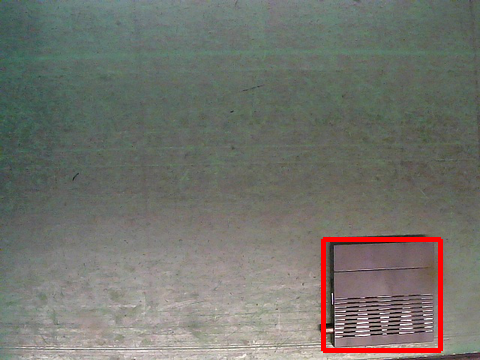

In [3]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122139.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.8730576038360596
200.0
scres[i 0.99996555
boxes [0.3183863  0.54709953 0.6176843  0.7949819 ]
rect,width=118.98353576660156height=107.74728655815125
(left, right, top, bottom) (262.60777473449707, 381.59131050109863, 114.61906313896179, 222.36634969711304)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F14A03F9278>}
bicycle
execute2 time 0.9472358226776123
1



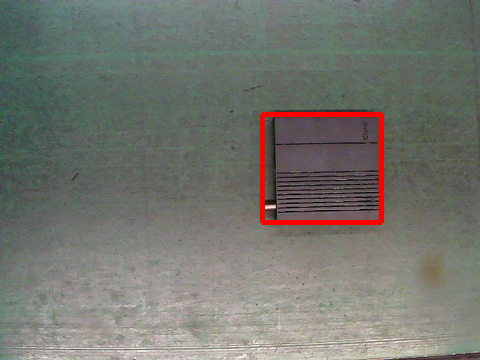

In [4]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122538.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.8752775192260742
200.0
scres[i 0.99999154
boxes [0.4375056  0.55044264 0.74096537 0.79994136]
rect,width=119.7593879699707height=109.24551486968994
(left, right, top, bottom) (264.2124652862549, 383.9718532562256, 157.5020170211792, 266.74753189086914)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F14A03F92B0>}
bicycle
execute2 time 0.9508469104766846
1



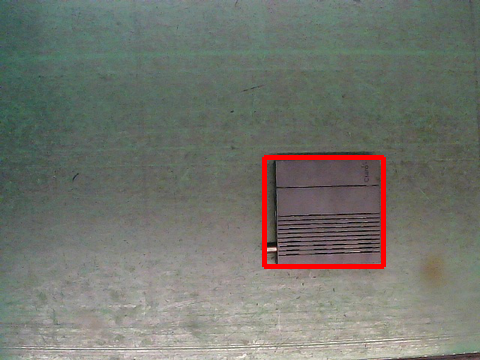

In [5]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122555.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.8950886726379395
200.0
scres[i 0.99996555
boxes [0.3183863  0.54709953 0.6176843  0.7949819 ]
rect,width=118.98353576660156height=107.74728655815125
(left, right, top, bottom) (262.60777473449707, 381.59131050109863, 114.61906313896179, 222.36634969711304)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F14A03F9518>}
bicycle
execute2 time 0.9693605899810791
1



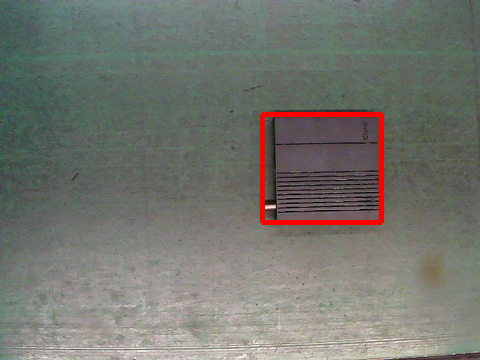

In [6]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122538.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
img = Image.open('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122538.jpg')

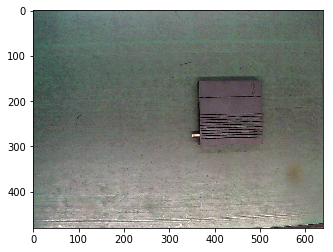

In [3]:
plt.imshow(img)

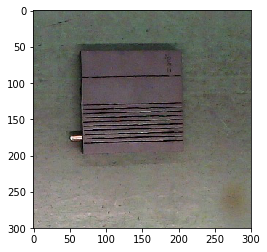

In [4]:
plt.imshow(img.crop((300, 100, 600, 400)))

In [5]:
img.crop((300, 100, 600, 400)).save('test1.jpg')

execute1 time 0.6845083236694336
200.0
scres[i 0.9991571
boxes [0.15442482 0.19307144 0.6709246  0.68131447]
rect,width=146.47290855646133height=154.9499362707138
(left, right, top, bottom) (57.921431958675385, 204.39434051513672, 46.32744491100311, 201.27738118171692)
{2: <PIL.Image.Image image mode=RGB size=300x300 at 0x7F14A03F91D0>}
bicycle
execute2 time 0.7146432399749756
1



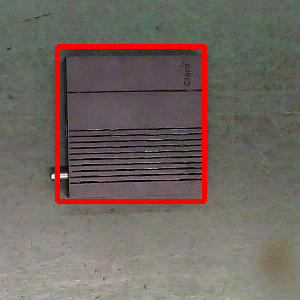

In [7]:
result=detect_objects('test1.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 2.0842885971069336
200.0
scres[i 0.9975794
boxes [0.4828648  0.01881403 0.761208   0.17751123]
rect,width=76.17465734481812height=75.15266418457031
(left, right, top, bottom) (9.030733108520508, 85.20539045333862, 130.373495221138, 205.5261594057083)
{2: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD278CB5BE0>}
bicycle
execute2 time 2.1512773036956787
1



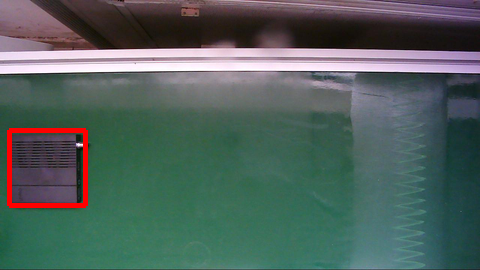

In [2]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C1.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 1.22914457321167
200.0
scres[i 0.99824524
boxes [0.4883621  0.19562262 0.7671122  0.36621982]
rect,width=81.88665390014648height=75.2625247836113
(left, right, top, bottom) (93.89885902404785, 175.78551292419434, 131.8577679991722, 207.1202927827835)
{2: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD1D10B80B8>}
bicycle
execute2 time 1.2962026596069336
1



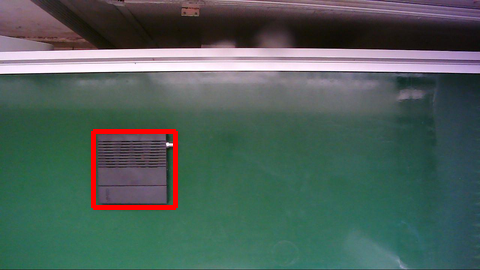

In [3]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C2.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 1.204097032546997
200.0
scres[i 0.9987853
boxes [0.48905033 0.3420731  0.76924026 0.511716  ]
rect,width=81.42858982086182height=75.65128147602081
(left, right, top, bottom) (164.19509410858154, 245.62368392944336, 132.04358875751495, 207.69487023353577)
scres[i 0.43887
boxes [0.46260384 0.35893577 0.742711   0.486175  ]
rect,width=61.0748291015625height=75.62893599271774
(left, right, top, bottom) (172.28917121887207, 233.36400032043457, 124.90303605794907, 200.5319720506668)
{2: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD1D10B81D0>, 1: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD1D10B83C8>}
bicycle
person
execute2 time 1.326514482498169
2



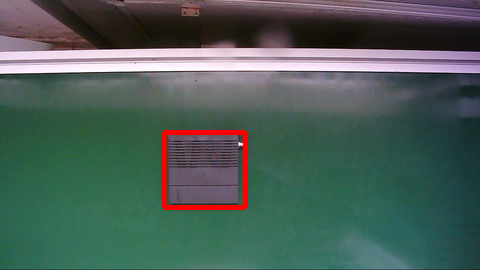

In [4]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C3.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 1.1968424320220947
200.0
scres[i 0.9977749
boxes [0.48745415 0.5001587  0.76442045 0.6649129 ]
rect,width=79.08199310302734height=74.78090196847916
(left, right, top, bottom) (240.0761890411377, 319.15818214416504, 131.61261945962906, 206.39352142810822)
scres[i 0.460899
boxes [0.46278095 0.5151612  0.74819356 0.63990027]
rect,width=59.8747444152832height=77.06140458583832
(left, right, top, bottom) (247.2773838043213, 307.1521282196045, 124.95085716247559, 202.0122617483139)
{2: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD1D10B8128>, 1: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD1D10B8400>}
bicycle
person
execute2 time 1.3184082508087158
2



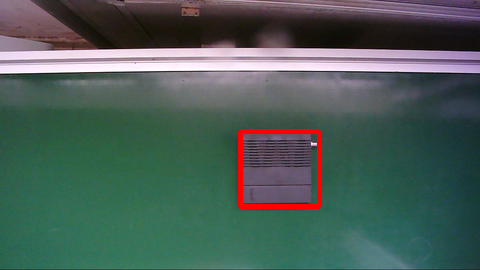

In [5]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C4.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 1.1981868743896484
200.0
scres[i 0.9946802
boxes [0.48346275 0.60390043 0.77023304 0.7661563 ]
rect,width=77.8828239440918height=77.42797672748566
(left, right, top, bottom) (289.87220764160156, 367.75503158569336, 130.53494274616241, 207.96291947364807)
scres[i 0.44071317
boxes [0.46264803 0.6249282  0.74476904 0.74942344]
rect,width=59.757728576660156height=76.17267072200775
(left, right, top, bottom) (299.9655246734619, 359.72325325012207, 124.91496920585632, 201.08763992786407)
{2: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD1D10B82B0>, 1: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD1D10B84A8>}
bicycle
person
execute2 time 1.3189377784729004
2



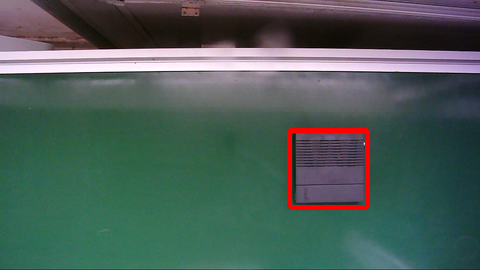

In [6]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C5.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 1.2026371955871582
200.0
scres[i 0.9989147
boxes [0.48263517 0.7593893  0.75728565 0.92445135]
rect,width=79.22979354858398height=74.15563076734543
(left, right, top, bottom) (364.5068550109863, 443.7366485595703, 130.31149595975876, 204.4671267271042)
{2: <PIL.Image.Image image mode=RGB size=480x270 at 0x7FD1D10B84E0>}
bicycle
execute2 time 1.2699553966522217
1



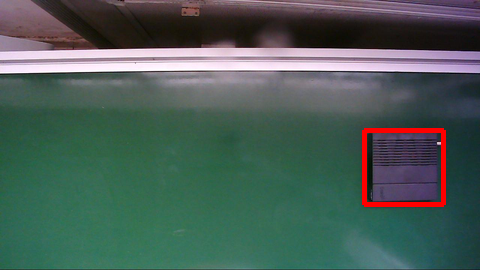

In [7]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C6.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

In [8]:
result=detect_objects('/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C7.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

FileNotFoundError: [Errno 2] No such file or directory: '/home/aadebugergf/Ai/dataxgf/machinevision/data/belt_output20190624_3/C7.jpg'

execute1 time 4.383949518203735
200.0
scres[i 0.9937577
boxes [0.71393555 0.4313837  0.9911666  0.6445321 ]
rect,width=102.31122493743896height=99.8031735420227
(left, right, top, bottom) (207.06417560577393, 309.3754005432129, 257.01679944992065, 356.81997299194336)
scres[i 0.54792076
boxes [0.6843807  0.45127302 0.9635831  0.6202133 ]
rect,width=81.09134674072266height=100.51286458969116
(left, right, top, bottom) (216.61105155944824, 297.7023983001709, 246.377055644989, 346.8899202346802)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F22F05A44E0>, 1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F224ABF3D68>}
bicycle
person
execute2 time 4.567205905914307
2



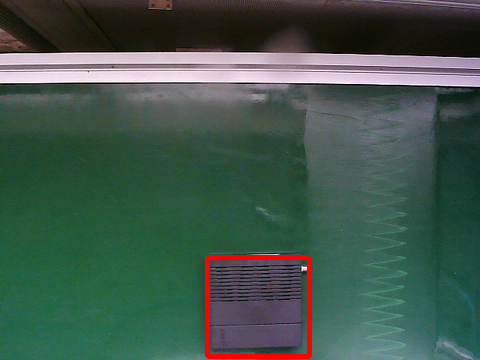

In [2]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628161926.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))